# Radial Profile Example

Isaac Cheng - October 2021

Some basic examples to show how to use the radial profile package. Steps to get started:

0. Requires: `astropy`, `numpy`, `matplotlib`, `photutils`, `radio_beam`
1. Download `radial_profile.py` and `radial_profile_utils.py` (both necessary) and put
   them in the same folder
2. Download this notebook and, if you don't want to fuss around with import statements,
   put this in the same folder as the two files above
3. You will need to replace my imported data with your data (e.g., from a FITS file). I
   cannot make my data publicly available

Finally, feature requests and bug reports are welcome! Service fees and shipping +
handling charges may apply.


In [1]:
# You do not need the following line. I only need it since I'm using VS Code with sshfs
%cd "/arc/home/IsaacCheng/coop_f2021/packages"

from radial_profile import RadialProfile

/arc/home/IsaacCheng/coop_f2021/packages


## Default call signature

For information only. Do not run this cell!


In [ ]:
# Do not run this cell!
import astropy.units as u

my_radial_profile_object = RadialProfile(
    data,
    center,
    inclination,
    position_angle,  # PA is defined to be 0 degrees at North and increases Eastward (CCW)
    noise=None,
)

my_radial_profile_object.calc_radial_profile(
    i_threshold=None,  # inclination threshold for what is considered "high inclination" 
    n_annuli=None,     # number of annuli to fit
    snr_cutoff=None,   # fit annuli until SNR dips below this value
                       # N.B. data and noise should be background-subtracted
    max_snr_annuli=5,  # maximum number of annuli to fit if using snr_cutoff
    min_width=None,    # minimum semi-major/minor axis length or annulus width
    min_width_ax="minor",  # "minor" or "major". The axis along which min_width is defined
    header=None,       # header of the FITS file
    wcs=None,          # astropy.wcs.WCS object corresponding to the FITS file
    include_bad=True,  # do not include NaNs/infs in any calculations
                       # If True, include NaNs/infs as zeros in calculations
    method="exact",    # "exact" or "center" or "subpixel"
    func="median",     # "mean" or "median"
    debug_plot=False,  # if True, show intermediate plots (warning: there are a lot!)
    is_radio=True,     # if min_width not specified, automatically set minimum annulus
                       # width to beam width
    header_min_width_key="IQMAX",  # if min_width not specified and is_radio is False,
                                   # determine minimum annulus width using this header key
    header_min_width_unit=u.arcsec,  # the unit corresponding to the header_min_width_key
    high_i_height=None     # the size of the rectangle along the minor axis direction
    bootstrap_errs=False,  # estimate the uncertainty in the average using bootstrapping
    n_bootstraps=100,      # number of bootstrap iterations to use
    n_samples=None,        # number of samples to use per bootstrap iteration
                           # If None, use the number of data points within the annulus
    bootstrap_seed=None,   # seed to use for bootstrapping. Does not affect global seed
)


## Low Inclination Galaxy


### Import Data


In [2]:
import astropy.coordinates as coord
import numpy as np
from astropy.io import fits

co_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"
data_co, header_co = fits.getdata(co_path, header=True)
unc_co = fits.getdata(co_unc_path)  # uncertainty
centre_co = coord.SkyCoord(
    ra="12h25m22.16s", dec="+10d01m00.12s", frame=header_co["RADESYS"].lower()
)
inclination_co = 61  # inclination, degrees
pa_co = 158          # position angle, degrees
# 
# Mask background
# 
isgood_co = np.isfinite(data_co) & np.isfinite(unc_co)
data_co[~isgood_co] = np.nan
unc_co[~isgood_co] = np.nan

### Generate radial profile


In [3]:
# 
# Initialize RadialProfile object
# 
NGC4380_no_rp = RadialProfile(data_co, centre_co, inclination_co, pa_co, noise=unc_co)
# 
# Generate radial profile
# 
NGC4380_rp = NGC4380_no_rp.calc_radial_profile(
    n_annuli=5,           # number of annuli to fit
    # snr_cutoff=0,       # noise cannot be None (when initializing RadialProfile object)
    # max_snr_annuli=5,   # maximum number of annuli to fit if using snr_cutoff
    header=header_co,
    include_bad=False,    # do not include NaNs/infs in any calculations
                          # If True, include NaNs/infs as zeros in calculations
    func="mean",          # "mean" or "median"
    is_radio=True,
    bootstrap_errs=True,  # estimate standard error on the mean
                          # Also see uncetainty section below
    n_bootstraps=100,
    bootstrap_seed=314,   # for reproducibility if anyone has the same data
)

Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000014364


### See all public methods and attributes of the object


In [4]:
print(
    "Public attributes and functions:\n",
    [attr for attr in dir(NGC4380_rp) if not attr.startswith("_")],
)
print("rp_options attribute:\n", NGC4380_rp.rp_options.keys())
print("Include bad:", NGC4380_rp.rp_options["include_bad"])

Public attributes and functions:
 ['a_ins', 'a_outs', 'annuli', 'avg_data', 'avg_data_err', 'avg_noise', 'avg_noise_err', 'b_ins', 'b_outs', 'calc_area', 'calc_radial_profile', 'center', 'copy', 'correct_for_i', 'data', 'data_area_masks', 'i', 'noise', 'noise_area_masks', 'pa', 'radii', 'rp_options', 'std_data', 'std_noise']
rp_options attribute:
 dict_keys(['i_threshold', 'n_annuli', 'snr_cutoff', 'max_snr_annuli', 'min_width', 'min_width_ax', 'header', 'wcs', 'include_bad', 'func', 'method', 'is_radio', 'header_min_width_key', 'header_min_width_unit', 'high_i_height', 'bootstrap_errs', 'n_bootstraps', 'n_samples', 'bootstrap_seed'])
Include bad: False


### Calculate the uncertainty in integrated intensity

Use Eq. (8) of Brown et al. (2021). This applies to my example data above. May not apply
to yours


In [5]:
import radial_profile_utils as rpu
#
# Calculate the number of pixels included in each annulus
# 
NGC4380_data_area, NGC4380_noise_area = NGC4380_rp.calc_area()  # these should be equal
# 
# Apply Eq. (8) of Brown et al. (2021) to get the uncertainty in the intensity profile
# 
beam_major, beam_minor, _ = rpu.get_beam_size_px(header_co)
beam_area = np.pi * (beam_major / 2) * (beam_minor / 2)  # area of ellipse in pixel units
num_beams = NGC4380_data_area / beam_area
unc_avg_co = NGC4380_rp.std_data * np.sqrt(num_beams)  # Eq. (8) of Brown et al. (2021)
# ? I think there may be a typo in the version of the paper I have...
# ? unc_avg_co should be DIVIDED by sqrt(num_beams) since num_beams is effectively the
# ? "sample size"...
print("Num beams:\t\t\t\t", num_beams)
print("Standard deviation of data:\t\t", NGC4380_rp.std_data)
print("Brown et al. (2021) uncertainty:\t", unc_avg_co)

Num beams:				 [ 8.25066136 24.75198408 41.25330679 51.58228    12.55190297]
Standard deviation of data:		 [1.5643997  0.6557115  0.35568345 0.45986754 0.2521688 ]
Brown et al. (2021) uncertainty:	 [4.49357616 3.26225429 2.28450989 3.30280568 0.89340038]


### Calculate the standard error.

Notice how well it agrees with the estimate derived from bootstrapping (as expected)


In [6]:
# See https://en.wikipedia.org/wiki/Standard_error#Exact_Value.
# Assumes independent samples
standard_error = NGC4380_rp.std_data / np.sqrt(NGC4380_data_area)
print("Standard Errors:\t", standard_error)
print("Bootstrapping Errors:\t", NGC4380_rp.avg_data_err)

Standard Errors:	 [0.13656704 0.03304839 0.01388599 0.01605554 0.01784757]
Bootstrapping Errors:	 [0.15091145 0.03254746 0.01779456 0.01625375 0.02319953]


### Plot the radial profile

Note that the average radius of an ellipse or annulus is defined as the arithmetic mean of
the inner and outer circularized radii. See the `calc_radius()` function in
`radial_profile_utils.py` for more information.


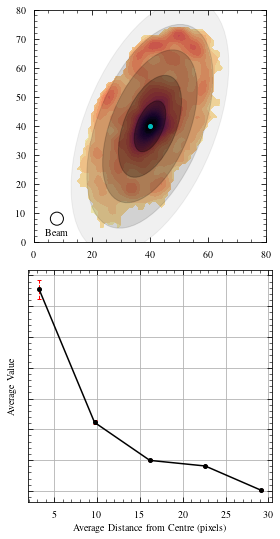

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
#
fig = plt.figure(figsize=mpl.figure.figaspect(1.9))
ax1 = fig.add_subplot(2, 1, 1)
#
# Plot data
#
img1 = ax1.contourf(data_co, cmap="magma_r", levels=22)
ax1.plot(*NGC4380_rp.annuli[0].positions, "co", markersize=4)  # mark centre
# Add annuli form outer to inner
for num, annulus in enumerate(NGC4380_rp.annuli[::-1]):
    try:
        # EllipticalAnnulus attributes
        width = annulus.b_out
        height = annulus.a_out
    except AttributeError:
        # EllipticalAperture attributes
        width = annulus.b
        height = annulus.a
    ellipse = Ellipse(
        xy=annulus.positions,
        width=width * 2,  # full major/minor axis
        height=height * 2,  # full major/minor axis
        angle=(np.rad2deg(annulus.theta) - 90) % 360.0,  # since PA is 0 deg at North
        ls="-",
        edgecolor="k",
        fc="k",
        alpha=0.3 * (num + 1) / len(NGC4380_rp.annuli),
        lw=1,
        zorder=2,
    )
    ax1.add_patch(ellipse)
# Add beam size
co_beam_major, co_beam_minor, co_beam_pa = rpu.get_beam_size_px(header_co)
xbeam, ybeam = 8, 8
ellipse = Ellipse(
    xy=(xbeam, ybeam),
    width=co_beam_minor,
    height=co_beam_major,
    angle=(co_beam_pa - 90) % 360.0,  # PA is 0 deg at North & increases CCW by convention
    ls="-",
    edgecolor="k",
    fc="None",
    lw=1,
    zorder=2,
)
ax1.add_patch(ellipse)
xtxt, ytxt = (xbeam - 4, ybeam - 5.5)
ax1.text(xtxt, ytxt, "Beam")
ax1.grid(False)
ax1.set_aspect("equal")
ax1.set_xlim(0, data_co.shape[1])
ax1.set_ylim(0, data_co.shape[0])
#
ax2 = fig.add_subplot(2, 1, 2)
ebar2 = ax2.errorbar(
    x=NGC4380_rp.radii,
    y=NGC4380_rp.avg_data,
    # yerr=standard_error,         # standard error on the mean
    yerr=NGC4380_rp.avg_data_err,  # uncertainty in the mean from bootstrapping
    # yerr=unc_avg_co,             # uncertainty using Eq. (8) of Brown et al. (2021)
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar2[-1][0].set_linestyle("--")
ax2.set_xlabel("Average Distance from Centre (pixels)")
ax2.set_ylabel("Average Value")
ax2.set_yticklabels([])  # hide exact values
#
fig.tight_layout()
plt.show()

### Correct for inclination

This is not necessary for my example data. Nonetheless, I will briefly show how this is
done


In [8]:
# N.B. Correcting for inclination only affects the data, noise, avg_data, and avg_noise
# attributes.
# Since we are multiplying everything by a constant, there is no effect on the standard
# deviation, standard error, etc.
NGC4380_rp_corrected = NGC4380_rp.correct_for_i(i_replacement=80)

In [9]:
# Hide exact values
rng = np.random.default_rng()
rand_val = rng.uniform(low=1, high=10)
# 
print("Uncorrected avg data:\t", NGC4380_rp.avg_data * rand_val)
print("Corrected avg data:\t", NGC4380_rp_corrected.avg_data * rand_val)
print("Uncorrected avg noise:\t", NGC4380_rp.avg_noise * rand_val)
print("Corrected avg noise:\t", NGC4380_rp_corrected.avg_noise * rand_val)

Uncorrected avg data:	 [18.0134454   7.69928078  4.75008603  4.31572862  2.45232896]
Corrected avg data:	 [8.73309162 3.73268539 2.3028874  2.09230675 1.18891267]
Uncorrected avg noise:	 [0.04796779 0.02251745 0.01560822 0.0135273  0.02574535]
Corrected avg noise:	 [0.02325525 0.01091668 0.00756702 0.00655816 0.01248159]


## High Inclination Galaxy

A galaxy is highly inclined if it has an inclination >= some inclination threshold (e.g.,
80 degrees).

Here, instead of fitting ellipses/annuli to the galaxies, we fit rectangles/rectangular
annuli (the latter are more similar to "rectangular sandwiches"). The width (along the
major axis direction) of these rectangles  are determined by min_width and the height
(along the minor axis direction) is determined by high_i_height.

If high_i_height is "min_width", the height of the rectangles/rectangular sandwiches will
be equal to min_width. If high_i_height is a float, it should be in pixel units. If
high_i_height is an astropy Quantity, remember to also pass in either the header or WCS
object. Finally, if high_i_height is None, automatically extend the region to the edges of
the image (but be careful of the include_bad keyword!).

If you're ever unsure of what region is used to calculate your values (e.g., mean/median,
standard deviation, etc.), simply plot the data_area_masks to see the included
pixels/spaxels and their weights. An example is shown near the end of this notebook.


### Import Data


In [10]:
import astropy.coordinates as coord
import numpy as np
from astropy.io import fits

co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4222/NGC4222_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
co_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4222/NGC4222_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"
data_co, header_co = fits.getdata(co_path, header=True)
unc_co = fits.getdata(co_unc_path)  # uncertainty
centre_co = coord.SkyCoord(
    ra="12h16m22.56s", dec="+13d18m25.20s", frame=header_co["RADESYS"].lower()
)
inclination_co = 90  # inclination, degrees
pa_co = 238          # position angle, degrees
# 
# Mask background
# 
isgood_co = np.isfinite(data_co) & np.isfinite(unc_co)
data_co[~isgood_co] = np.nan
unc_co[~isgood_co] = np.nan

### Generate radial profile


In [11]:
NGC4222 = RadialProfile(data_co, centre_co, inclination_co, pa_co, noise=unc_co)

NGC4222_rp = NGC4222.calc_radial_profile(
    i_threshold=80,
    snr_cutoff=10,
    max_snr_annuli=15,
    min_width=None,
    header=header_co,
    include_bad=False,
    method="exact",
    func="mean",
    is_radio=True,
    high_i_height=None,  # "min_width", float, astropy Quantity, or None
    bootstrap_errs=True,
    n_bootstraps=100,
    bootstrap_seed=314,
)

Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000020844
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Info: Fitting rectangles according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 188.96629087509993
Iter 2: average SNR = 308.21707482954565
Iter 3: average SNR = 299.0330186470217
Iter 4: average SNR = 171.23510791671205
Iter 5: average SNR = 124.16581195934518
Iter 6: average SNR = 101.1088324220678
Iter 7: average SNR = 124.61055104694796
Iter 8: average SNR = 37.93095358753315
Stopped creating rectangles after 8 iterations
Average SNR of most recent successful fit: 37.93095358753315
Average SNR of next rectangle: 0.615158221521524


### Plot the radial profile

The regions with the same shades of grey are the "rectangles" for that radial profile bin. Note that this does not show the effects of include_bad (see the following example instead)


In [12]:
def rotate_ccw(x, y, theta, origin=(0, 0)):
    """
    Rotate a point or array of points by theta (in radians) counter-clockwise about some
    specified origin.
    
    Parameters:
      x, y :: scalar or array-like
        The x and y coordinates of the points to be rotated
      theta :: scalar or array-like
        The counter-clockwise angle of rotation (in radians)
      origin :: tuple or array-like with shape (2, *np.shape(x))
        The (x, y) coordinates about which to rotate the points
    """
    xnew = x - origin[0]
    ynew = y - origin[1]
    xnew2 = np.cos(theta) * xnew - np.sin(theta) * ynew
    ynew2 = np.sin(theta) * xnew + np.cos(theta) * ynew
    xnew2 = xnew2 + origin[0]
    ynew2 = ynew2 + origin[1]
    return xnew2, ynew2

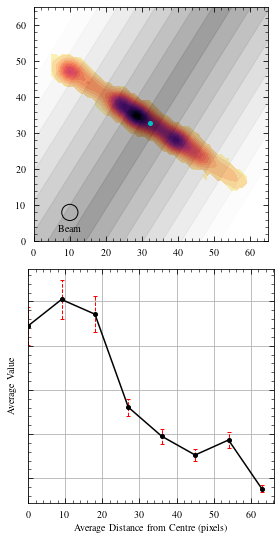

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
import radial_profile_utils as rpu

fig = plt.figure(figsize=mpl.figure.figaspect(1.9))
ax1 = fig.add_subplot(2, 1, 1)
#
# Plot data
#
img1 = ax1.contourf(data_co, cmap="magma_r", levels=22)
ax1.plot(*NGC4222_rp.annuli[0].positions, "co", markersize=4)  # mark centre
# Add rectangles from outer to inner
for num, rectangle in enumerate(NGC4222_rp.annuli[::-1]):
    try:
        # RectangularAperture attributes
        width = rectangle.w
        height = rectangle.h
    except AttributeError:
        # RectangularAnnulus (aka RectangularSandwich) attributes
        width = rectangle.w_out
        height = rectangle.h_out
    xy = (rectangle.positions[0] - height / 2, rectangle.positions[1] + width / 2)
    xy = rotate_ccw(
        *xy, rectangle.theta + np.pi/2, origin=rectangle.positions
    )
    rect = Rectangle(
        xy=xy,
        width=width,
        height=height,
        angle=np.rad2deg(rectangle.theta) % 360.0,  # same convention as PA
        ls="-",
        edgecolor="k",
        fc="k",
        alpha=0.1 * (num + 1) / len(NGC4222_rp.annuli),
        lw=1,
        zorder=2,
    )
    ax1.add_patch(rect)
# Add beam size
co_beam_major, co_beam_minor, co_beam_pa = rpu.get_beam_size_px(header_co)
xbeam, ybeam = 10, 8
ellipse = Ellipse(
    xy=(xbeam, ybeam),
    width=co_beam_minor,
    height=co_beam_major,
    angle=(co_beam_pa - 90) % 360.0,  # PA is 0 deg at North & increases CCW by convention
    ls="-",
    edgecolor="k",
    fc="None",
    lw=1,
    zorder=2,
)
ax1.add_patch(ellipse)
xtxt, ytxt = (xbeam - 3.25, ybeam - 5.5)
ax1.text(xtxt, ytxt, "Beam")
ax1.grid(False)
ax1.set_aspect("equal")
ax1.set_xlim(0, data_co.shape[0])
ax1.set_ylim(0, data_co.shape[1])
#
ax2 = fig.add_subplot(2, 1, 2)
ebar2 = ax2.errorbar(
    x=NGC4222_rp.radii,
    y=NGC4222_rp.avg_data,
    yerr=NGC4222_rp.avg_data_err,     # uncertainty in the mean from bootstrapping
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar2[-1][0].set_linestyle("--")
ax2.set_xlabel("Average Distance from Centre (pixels)")
ax2.set_ylabel("Average Value")
ax2.set_xlim(left=0)
ax2.set_yticklabels([])  # hide exact values
#
fig.tight_layout()
plt.show()

### Check what regions are included in the radial profile calculations

Notice how the SNR values are not affected since the area of the regions cancel out! This
is only true if you use func="mean". Note that the individual signal and noise values *do*
change depending on the area of the region, however. Again, it is *only* the ratio of the
mean signal (data) value to the mean noise value that is not affected.


Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000020844
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Info: Fitting rectangles according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 188.96629087509993
Iter 2: average SNR = 308.21707482954565
Iter 3: average SNR = 299.0330186470217
Iter 4: average SNR = 171.23510791671205
Iter 5: average SNR = 124.16581195934518
Iter 6: average SNR = 101.1088324220678
Iter 7: average SNR = 124.61055104694796
Iter 8: average SNR = 37.93095358753315
Stopped creating rectangles after 8 iterations
Average SNR of most recent successful fit: 37.93095358753315
Average SNR of next rectangle: 0.615158221521524


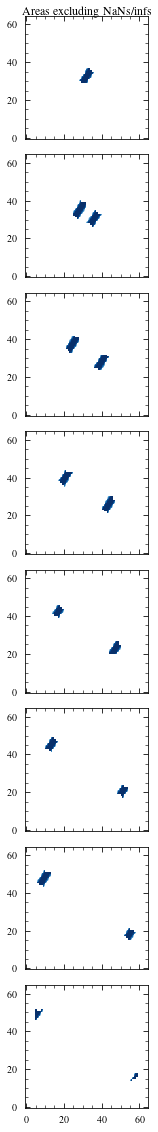

In [14]:
NGC4222_no_bad = NGC4222.calc_radial_profile(
    i_threshold=80,
    snr_cutoff=10,
    max_snr_annuli=15,
    min_width=None,
    header=header_co,
    include_bad=False,
    method="exact",
    func="mean",
    is_radio=True,
    high_i_height=None,  # "min_width", float, astropy Quantity, or None
    bootstrap_errs=True,
    n_bootstraps=100,
    bootstrap_seed=314,
)


fig, axs = plt.subplots(
    nrows=len(NGC4222_no_bad.data_area_masks),
    figsize=mpl.figure.figaspect(len(NGC4222_no_bad.data_area_masks)),
)
for ax, region in zip(axs, NGC4222_no_bad.data_area_masks):
    ax.imshow(region, cmap="Blues", origin="lower")
    ax.grid(False)
for ax in axs[:-1]:
    ax.set_xticklabels([])
fig.suptitle("Areas excluding NaNs/infs")
plt.tight_layout()
plt.show()

Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000020844
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli


Info: Fitting rectangles according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 188.96629087509993
Iter 2: average SNR = 308.2170748295457
Iter 3: average SNR = 299.03301864702166
Iter 4: average SNR = 171.23510791671208
Iter 5: average SNR = 124.16581195934518
Iter 6: average SNR = 101.10883242206782
Iter 7: average SNR = 124.61055104694795
Iter 8: average SNR = 37.93095358753316
Stopped creating rectangles after 8 iterations
Average SNR of most recent successful fit: 37.93095358753316
Average SNR of next rectangle: 0.6151582215215239


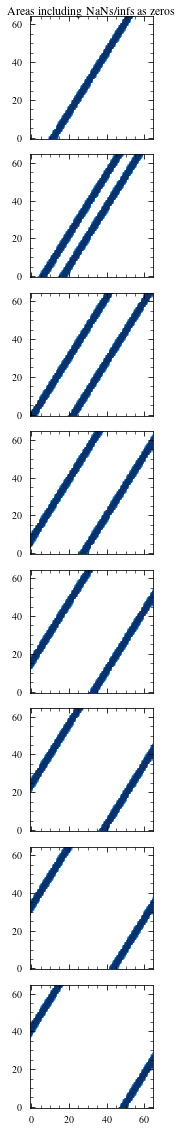

In [15]:
NGC4222_yes_bad = NGC4222.calc_radial_profile(
    i_threshold=80,
    snr_cutoff=10,
    max_snr_annuli=15,
    min_width=None,
    header=header_co,
    include_bad=True,
    method="exact",
    func="mean",
    is_radio=True,
    high_i_height=None,  # "min_width", float, astropy Quantity, or None
    bootstrap_errs=True,
    n_bootstraps=100,
    bootstrap_seed=314,
)


fig, axs = plt.subplots(
    nrows=len(NGC4222_yes_bad.data_area_masks),
    figsize=mpl.figure.figaspect(len(NGC4222_yes_bad.data_area_masks)),
)
for ax, region in zip(axs, NGC4222_yes_bad.data_area_masks):
    ax.imshow(region, cmap="Blues", origin="lower")
    ax.grid(False)
for ax in axs[:-1]:
    ax.set_xticklabels([])
fig.suptitle("Areas including NaNs/infs as zeros")
plt.tight_layout()
plt.show()
